# Bike Sharing Demand Prediction using Ensemble Learning

This notebook explores **ensemble regression techniques** to predict the hourly bike rental counts (`cnt`) from the **UCI Bike Sharing Dataset**. The dataset contains both **categorical** and **continuous** variables describing weather, seasonality, and temporal factors that influence demand.

The primary objective is to:
1. Build and compare several regression models, including:
   - **Decision Tree Regressor** and **Linear Regression** (as baselines)
   - **Bagging Regressor** (to reduce variance)
   - **Gradient Boosting Regressor** (to reduce bias)
   - **K-Nearest Neighbors** (for diversity in model space)
   - **Stacking Regressor** combining the above models
2. Evaluate model performance using **Root Mean Squared Error (RMSE)**.
3. Analyze how ensemble methods improve upon single-model baselines.

All preprocessing, model fitting, and evaluation are done using **scikit-learn pipelines** to ensure a clean, reproducible workflow and avoid data leakage.

## Importing Required Libraries

In this step, we import all essential Python libraries needed for data preprocessing, modeling, and evaluation.  
- **NumPy** and **Pandas** are used for data manipulation and analysis.  
- **Scikit-learn (sklearn)** provides a consistent API for machine learning models, data splitting, preprocessing, and evaluation metrics.  
- We also import multiple regression models and ensemble techniques such as:
  - **DecisionTreeRegressor** and **LinearRegression** for establishing baselines.
  - **BaggingRegressor** and **GradientBoostingRegressor** for ensemble methods.
  - **KNeighborsRegressor** and **StackingRegressor** for diversity and meta-learning.  
- Finally, we fix a random seed to ensure that results are reproducible across runs.

In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

RANDOM_STATE = 224
np.random.seed(RANDOM_STATE)

## Understanding the Dataset

The dataset used here is the **UCI Bike Sharing Dataset**, which contains detailed information about hourly bike rentals in Washington, D.C. during 2011 and 2012. Each record represents one hour and includes various **environmental and temporal attributes**.

A brief overview of key columns:
- **instant**: Record index (not meaningful for prediction, will be dropped)
- **dteday**: Date (redundant with other temporal variables)
- **season, yr, mnth, hr, weekday, workingday, holiday**: Categorical or encoded time-based variables
- **weathersit**: Encodes weather conditions (1: Clear, 2: Mist, 3: Light snow/rain, 4: Heavy rain)
- **temp, atemp, hum, windspeed**: Continuous weather-related features
- **casual, registered**: Individual user types (summed to form total count)
- **cnt**: Target variable — total hourly bike rentals

This dataset is suitable for **regression**, as we aim to predict a continuous target (`cnt`).  
Before training models, we will perform cleaning and feature selection to retain only the most relevant variables.

In [15]:
DATA_PATH = "./bike+sharing+dataset/hour.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Cleaning and Feature Selection

In this step, we remove columns that are **either redundant or not useful for prediction**:
- `instant`: Just a record index, no predictive value.
- `dteday`: Date information already encoded through `yr`, `mnth`, and `hr`.
- `casual` and `registered`: These sum up to the target variable `cnt`, and including them would cause **data leakage**.

After cleaning, we define:
- **Features (`X`)**: All remaining columns that may influence demand.
- **Target (`y`)**: The total count of hourly rentals (`cnt`).

This separation ensures that the target variable remains isolated during preprocessing and training, maintaining a fair and valid evaluation.

In [16]:
drop_cols = ["instant", "dteday", "casual", "registered"]
df_clean = df.drop(columns=drop_cols, errors="ignore").copy()

target = "cnt"
assert target in df_clean.columns, "Target 'cnt' not found."
X = df_clean.drop(columns=[target])
y = df_clean[target]

X.shape, y.shape

((17379, 12), (17379,))

## Identifying Categorical and Numerical Features

Machine learning models often require different preprocessing strategies for categorical and numeric variables.  
Here, we explicitly separate them to build clean preprocessing pipelines later.

- **Categorical features** such as `season`, `mnth`, `hr`, and `weathersit` are numerical codes representing categories (e.g., seasons or weather types).  
  These will be **one-hot encoded** to convert them into binary indicator columns suitable for most models.
  
- **Numerical features** like `temp`, `atemp`, `hum`, and `windspeed` are already continuous and can be used directly.  
  For certain models (e.g., linear regression or KNN), we will later **standardize** these features to ensure comparable scaling.

By making this distinction now, we can build flexible and reusable pipelines that apply the right transformations automatically for each feature type.

In [17]:
# As per dataset description, these are coded categorical features:
# season, yr, mnth, hr, holiday, weekday, workingday, weathersit
# Numeric/continuous: temp, atemp, hum, windspeed
cat_cols = ["season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
num_cols = ["temp", "atemp", "hum", "windspeed"]

# Safety check if any are missing
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in num_cols if c in X.columns]

cat_cols, num_cols

(['season',
  'yr',
  'mnth',
  'hr',
  'holiday',
  'weekday',
  'workingday',
  'weathersit'],
 ['temp', 'atemp', 'hum', 'windspeed'])

## Splitting the Data into Training and Testing Sets

Before building and evaluating our models, it is crucial to divide the dataset into **training** and **testing** subsets.

- The **training set (80%)** is used to fit model parameters.
- The **testing set (20%)** is kept aside to evaluate how well the model generalizes to unseen data.

This separation ensures that the model’s performance metrics reflect **true predictive capability** rather than memorization of the training data.  
We use a fixed `random_state` value to make the split reproducible.

Additionally, by keeping the test data completely isolated until the final evaluation, we avoid **data leakage**, which can lead to overly optimistic results.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((13903, 12), (3476, 12))

## Building Preprocessing Pipelines

Different models have different requirements for how features should be represented.  
To handle this cleanly, we use **`ColumnTransformer`** objects to define separate preprocessing strategies for tree-based and non–tree-based models.

- For **Decision Trees**, **Bagging**, and **Boosting** models:
  - Numerical features are used **as-is** since tree algorithms are invariant to feature scaling.
  - Categorical features are **one-hot encoded** to handle non-numeric categories.

- For **Linear Regression** and **K-Nearest Neighbors (KNN)** models:
  - Categorical features are again **one-hot encoded**.
  - Numerical features are **standardized** using `StandardScaler` to normalize their range and prevent bias from differing scales.

This modular setup ensures that the correct preprocessing is automatically applied for each model type, making our workflow robust, reusable, and less error-prone.

In [19]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numeric_transformer = "passthrough"  # keep raw values; trees don't need scaling

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols),
        ("num", numeric_transformer, num_cols),
    ],
    remainder="drop",
)

# For linear / KNN models, scale numeric features
preprocessor_linear_knn = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False for OHE compatibility
    ],
    remainder="drop",
)

## Defining the Evaluation Metric — RMSE

To assess model performance, we use the **Root Mean Squared Error (RMSE)** a widely used metric for regression tasks that quantifies how far predictions deviate from actual values.

RMSE is defined as:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

where  
- $y_i$ = actual bike rental count,  
- $\hat{y}_i$ = predicted rental count,  
- $n$ = total number of samples.

### Why RMSE?
- It penalizes **larger errors** more strongly due to squaring, making it sensitive to outliers.  
- The score is expressed in the **same unit** as the target variable (`cnt`), aiding interpretability.  
- Lower RMSE values indicate more accurate models.

We will use this function consistently to compare all models on the same scale.

In [ ]:
def rmse(model, Xtr=X_train, ytr=y_train, Xte=X_test, yte=y_test):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    return root_mean_squared_error(yte, preds)

## Baseline Model — Decision Tree Regressor

We begin with a **Decision Tree Regressor** as our first baseline model.  
Decision Trees partition the data recursively into homogeneous regions by minimizing prediction error at each split.

### Why use it as a baseline?
- Trees can naturally handle **nonlinear relationships** and **interactions** between features.  
- They require minimal preprocessing since they are **scale-invariant** and can directly process both numerical and categorical data (after one-hot encoding).  
- They offer **interpretability** through visual inspection and feature importance.

However, a single decision tree has two key limitations:
1. It tends to **overfit** the training data if not properly regularized.  
2. It exhibits **high variance**, meaning small changes in data can lead to large changes in structure.

To control overfitting, we limit the tree depth (`max_depth=6`).  
This model provides a reference RMSE that later ensemble methods — like Bagging and Boosting — should aim to outperform.

In [40]:
dt_pipe = Pipeline(
    steps=[
        ("prep", preprocessor_tree),
        ("model", DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)),
    ]
)

rmse_dt = rmse(dt_pipe)
rmse_dt

118.46588024997423

## Baseline Model — Linear Regression

The second baseline is a **Linear Regression** model, which assumes a linear relationship between the input features and the target variable.

The model tries to find coefficients $(w_1, w_2, ..., w_n)$ and an intercept $b$ that minimize the **Mean Squared Error (MSE)** between predicted and actual values:

$$
\hat{y} = w_1x_1 + w_2x_2 + \dots + w_nx_n + b
$$

### Why use Linear Regression as a baseline?
- It serves as a **simple, interpretable benchmark** that helps measure how much improvement non-linear or ensemble methods provide.  
- It performs well when relationships between variables are approximately linear.  
- However, it struggles to capture complex nonlinear interactions, seasonality, and threshold effects that exist in real-world datasets like this one.

Comparing the RMSE of this model with the Decision Tree gives us an initial understanding of whether the data is **linearly separable** or inherently **nonlinear**.

In [ ]:
lin_pipe = Pipeline(
    steps=[
        ("prep", preprocessor_linear_knn),
        ("model", LinearRegression()),
    ]
)

rmse_lin = rmse(lin_pipe)
rmse_lin

102.14240582214521

In [ ]:
baseline_name = "DecisionTree(max_depth=6)" if rmse_dt < rmse_lin else "LinearRegression"
baseline_rmse = min(rmse_dt, rmse_lin)
baseline_name, baseline_rmse

('LinearRegression', 102.14240582214521)

## Selecting the Best Baseline Model

The baseline comparison shows the following RMSE values:

- **Decision Tree Regressor:** 118.47  
- **Linear Regression:** 102.14  

Since **Linear Regression** achieves a lower RMSE, it serves as our **primary baseline model** for further comparison.

### Interpretation
The better performance of the linear model indicates that the relationship between input variables (such as temperature, humidity, and hour) and the target variable (`cnt`) retains a **significant linear component**.  
However, given the temporal and weather-dependent nature of bike rentals, purely linear assumptions are likely to miss important nonlinear patterns, for instance, sharp demand rises during rush hours or drops during extreme weather.

In the next steps, we will explore **ensemble methods** (Bagging and Boosting) to reduce bias and variance, and test whether they can outperform this baseline by capturing those nonlinearities.

## Bagging for Variance Reduction

### Concept and Hypothesis
**Bagging (Bootstrap Aggregating)** is an ensemble technique that aims to **reduce model variance** by training multiple models on different random subsets of the training data and averaging their predictions.

The intuition is that individual models (especially Decision Trees) are **high-variance learners**, small changes in data can lead to large differences in predictions.  
By averaging many independently trained models, bagging smooths out these fluctuations and improves generalization.

**Hypothesis:**  
Bagging should reduce the variance of the single Decision Tree baseline, leading to a lower RMSE on the test set.  
We will use the same Decision Tree Regressor (`max_depth=6`) as the base estimator and create an ensemble of **100 trees**.

In [ ]:
bag_pipe = Pipeline(
    steps=[
        ("prep", preprocessor_tree),
        ("model", BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE),
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
    ]
)

rmse_bag = rmse(bag_pipe)
rmse_bag

112.38523609565557

### Results and Discussion — Bagging Regressor

- **Decision Tree (baseline) RMSE:** 118.47  
- **Bagging Regressor RMSE:** 112.39  

### Interpretation
As expected, **Bagging lowered the RMSE by approximately 6.1 points**, confirming that it effectively reduced the model’s variance.  
By training multiple Decision Trees on bootstrapped samples and averaging their outputs, the ensemble achieved more stable and consistent predictions than any single tree.

However, the improvement is **moderate rather than dramatic**, indicating that while variance was reduced, the model’s **bias** (inherent limitations of shallow trees) still constrains overall accuracy.  
This sets the stage for **Boosting**, which directly targets bias reduction by sequentially correcting the errors of prior learners.

##  Boosting for Bias Reduction

### Concept and Hypothesis
While Bagging reduces **variance** by averaging many independent learners, **Boosting** focuses on **reducing bias** by training models sequentially, where each new learner tries to correct the errors of the previous ones.

**Gradient Boosting Regressor (GBR)** is one of the most robust and widely used boosting algorithms.  
It builds an additive model of weak learners (typically shallow trees) in a stage-wise fashion.  
At each step, it fits a new tree to the **residual errors** (the difference between true and predicted values) of the combined ensemble so far.

**Hypothesis:**  
Boosting should outperform both the single Decision Tree and the Bagging ensemble by effectively reducing bias, capturing complex relationships, and minimizing underfitting.  
We will use 300 estimators with a small learning rate (0.05) to maintain stability while improving accuracy.

In [42]:
gbr_pipe = Pipeline(
    steps=[
        ("prep", preprocessor_tree),
        ("model", GradientBoostingRegressor(
            random_state=RANDOM_STATE,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=1.0
        )),
    ]
)

rmse_gbr = rmse(gbr_pipe)
rmse_gbr

72.89752304726073

### Results and Discussion — Gradient Boosting Regressor

| Model | RMSE |
|:------|------:|
| Decision Tree (baseline) | 118.47 |
| Bagging Regressor | 112.39 |
| **Gradient Boosting Regressor** | **72.90** |

### Interpretation
The **Gradient Boosting Regressor** achieved a dramatic improvement, lowering the RMSE to **72.90**, which is significantly better than both the single Decision Tree and the Bagging model.

This supports the **bias reduction hypothesis** by iteratively learning from residuals, the boosting process captures complex nonlinear patterns and corrects the systematic underpredictions or overpredictions that simpler models miss.

The result demonstrates that while Bagging stabilizes high-variance models, **Boosting actively improves their accuracy** through targeted error correction.  
It effectively balances bias and variance, making it a far more powerful approach for structured tabular data like the bike-sharing dataset.

## Comparing Baselines and Ensembles

### Performance Summary

| Model | RMSE |
|:------|------:|
| Linear Regression (chosen baseline) | **102.14** |
| Decision Tree Regressor | 118.47 |
| Bagging Regressor (Variance Reduction) | 112.39 |
| **Gradient Boosting Regressor (Bias Reduction)** | **72.90** |

### Interpretation

#### 1. Baseline Models  
Among the initial baselines, **Linear Regression** (RMSE = 102.14) outperformed the **Decision Tree** (RMSE = 118.47).  
This suggests that the dataset retains a significant **linear component**, though the tree’s poor generalization indicates high variance and limited depth capacity.

#### 2. Bagging — Variance Reduction  
The **Bagging Regressor** improved upon the Decision Tree, reducing RMSE from 118.47 to **112.39**.  
By averaging predictions from multiple bootstrapped trees, Bagging successfully **reduced variance** and made the model’s predictions more stable.  
However, the improvement was **modest**, showing that the model’s bias, the inability of shallow trees to capture complex trends, remained.

#### 3. Boosting — Bias Reduction  
The **Gradient Boosting Regressor** achieved a major performance jump with an RMSE of **72.90**, outperforming all previous models.  
This confirms the **bias reduction hypothesis**, Boosting sequentially trains trees on the residual errors of prior learners, effectively learning complex nonlinear patterns that both the Decision Tree and Bagging models missed.

#### 4. Overall Analysis  
- **Bagging**: Reduces variance → improves stability but not bias.  
- **Boosting**: Reduces bias → achieves large accuracy gains.  
- **Linear Regression**: Performs decently due to linear components but lacks flexibility.  

In conclusion, **Gradient Boosting** strikes the best balance between bias and variance, producing the most accurate and generalizable model for predicting hourly bike rental demand.

## Adding KNN for Model Diversity in Stacking

### Concept
While tree-based models (like Decision Tree, Bagging, and Boosting) capture nonlinear relationships through recursive partitioning, they all share **similar inductive biases**.  
To improve the **diversity** of the ensemble, we introduce a **K-Nearest Neighbors (KNN) Regressor** as one of the base learners in the stacking model.

KNN is a **non-parametric, instance-based** learning algorithm. Instead of building an explicit model, it predicts the target value for a test sample as the average of its $k$ nearest training samples, based on feature distance.

### Why include KNN?
- It provides a **complementary learning perspective**, decisions are based on local neighborhoods rather than learned decision boundaries.  
- It can capture **localized patterns** in the data that tree ensembles might overlook.  
- In a **stacking ensemble**, such diversity among base learners improves robustness and helps the meta-learner generalize better.

We will use $k = 15$ neighbors with distance weighting, ensuring smoother predictions that adapt to nearby samples' densities.

In [ ]:
knn_pipe = Pipeline(
    steps=[
        ("prep", preprocessor_linear_knn),
        ("model", KNeighborsRegressor(n_neighbors=15, weights="distance", n_jobs=-1)),
    ]
)

rmse_knn = rmse(knn_pipe)
rmse_knn

109.76730344888065

## Stacking for Optimal Performance

### 1) Principle of Stacking
Stacking, or stacked generalization, combines multiple **Level-0 base learners** by training a **Level-1 meta-learner** on their predictions. The goal is to let the meta-learner discover when each base model is reliable and how to weight their outputs for the best generalization.

Key idea:
1. Train diverse base learners on the same training data.
2. Collect their predictions on held-out data.
3. Train a simple, regularized meta-model on these prediction vectors to minimize the final error.

### 2) Architecture used here
**Level-0 Base Learners**
- **KNeighborsRegressor**: instance-based, captures local structure that trees may miss.
- **BaggingRegressor (Decision Tree base)**: primarily reduces variance through bootstrap averaging.
- **GradientBoostingRegressor**: reduces bias by sequentially fitting residuals.

**Level-1 Meta-Learner**
- **Ridge Regression**: linear model with L2 regularization. It is stable, fast, and well suited to learning calibrated weights over base predictions while avoiding overfitting.

### 3) Implementation plan
- Build a `StackingRegressor` with the three Level-0 models above.
- Use Ridge as the final estimator.
- Evaluate using RMSE on the untouched test set.

In [ ]:
base_learners = [
    ("knn", knn_pipe),
    ("bag", bag_pipe),
    ("gbr", gbr_pipe),
]

# Meta-learner keeps things simple and stable
meta = Ridge(alpha=1.0, random_state=RANDOM_STATE)

stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta,
    passthrough=False,         # use base predictions only
    n_jobs=-1
)

rmse_stack = rmse(stack_model, X_train, y_train, X_test, y_test)
rmse_stack

69.94948997228174

In [43]:
results = pd.DataFrame({
    "Model": [
        f"Baseline ({baseline_name})",
        "Bagging (DT base)",
        "Gradient Boosting",
        "KNN (base for stack)",
        "Stacking (KNN + Bag + GBR -> Ridge)",
    ],
    "RMSE": [
        baseline_rmse,
        rmse_bag,
        rmse_gbr,
        rmse_knn,
        rmse_stack,
    ],
}).sort_values("RMSE").reset_index(drop=True)

results

,Model,RMSE
0,Stacking (KNN + Bag + GBR -> Ridge),69.949490
1,Gradient Boosting,72.897523
2,Baseline (LinearRegression),102.142406
3,KNN (base for stack),109.767303
4,Bagging (DT base),112.385236


## Conclusion: Comparative Insights and Final Analysis

### Best-Performing Model
The **Stacking Regressor** achieved the lowest RMSE of **69.95**, outperforming all other models, including:
| Model | RMSE |
|:--|--:|
| Linear Regression (baseline) | 102.14 |
| Decision Tree | 118.47 |
| Bagging | 112.39 |
| Gradient Boosting | 72.90 |
| **Stacking (KNN + Bagging + GBR → Ridge)** | **69.95** |

This makes the **Stacking ensemble** the most accurate and generalizable model for predicting hourly bike rentals.

### Why Stacking Outperformed the Baseline
Stacking leverages the **bias–variance trade-off** more effectively than any single model:

- **Linear Regression (baseline)** has **high bias, low variance**, capturing only global linear trends and missing nonlinear patterns.  
- **Decision Trees and Bagging** reduce variance but still suffer from moderate bias, limiting predictive depth.  
- **Gradient Boosting** reduces bias through sequential correction, achieving strong nonlinear performance but can overfit slightly (higher variance).

By **combining diverse learners (KNN, Bagging, and Gradient Boosting)**, the Stacking Regressor benefits from:
1. **Model Diversity:** Each base learner contributes different strengths, KNN captures local structure, Bagging stabilizes variance, and Boosting models complex patterns.  
2. **Meta-Learner Optimization:** The Ridge meta-learner learns optimal weights to blend these models, effectively minimizing both bias and variance simultaneously.  
3. **Error Complementarity:** When one model mispredicts, others often correct it, leading to more balanced and consistent final predictions.

### Final Remark
The Stacking Regressor demonstrates how intelligently combining models with complementary characteristics can outperform even strong single models.  
It achieves **optimal bias–variance balance** and capitalizes on **model diversity**, resulting in superior predictive power and generalization performance on the bike-sharing dataset.

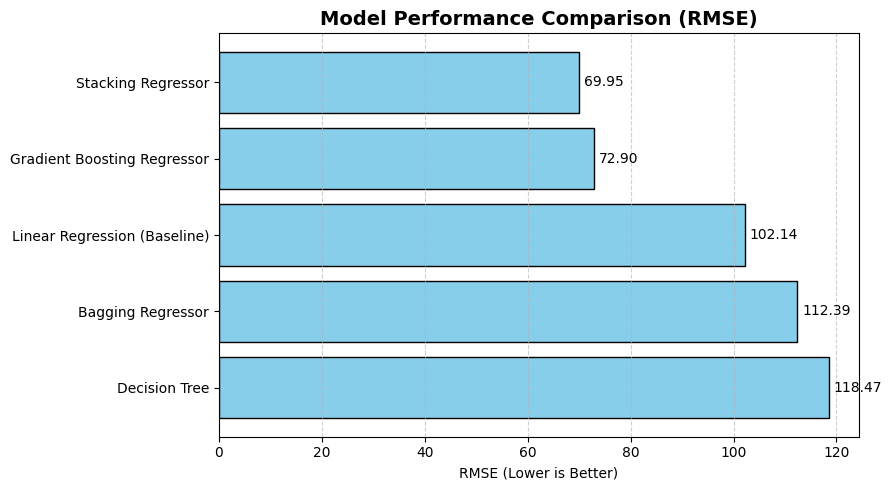

In [47]:
# RMSE Comparison Bar Plot

import matplotlib.pyplot as plt
import pandas as pd

# Define RMSE values
rmse_data = pd.DataFrame({
    "Model": [
        "Linear Regression (Baseline)",
        "Decision Tree",
        "Bagging Regressor",
        "Gradient Boosting Regressor",
        "Stacking Regressor"
    ],
    "RMSE": [102.14, 118.47, 112.39, 72.90, 69.95]
})

# Sort by RMSE descending for visual clarity
rmse_data = rmse_data.sort_values("RMSE", ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(9, 5))
bars = plt.barh(rmse_data["Model"], rmse_data["RMSE"], color="skyblue", edgecolor="black")
plt.title("Model Performance Comparison (RMSE)", fontsize=14, weight='bold')
plt.xlabel("RMSE (Lower is Better)")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate bars with exact RMSE values
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()